In [48]:
from google.colab import files
uploaded=files.upload()
print(uploaded)

Saving dataset.csv to dataset.csv
{'dataset.csv': b'ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime\r\n0,BHMBCCMKT01,577,26.14453614,91.73617216,61,car,low,1,0,04-10-2016,07:59:00\r\n1,BHMBCCMKT01,577,26.14453614,91.73617216,64,car,low,1,0,04-10-2016,08:25:00\r\n2,BHMBCCMKT01,577,26.14453614,91.73617216,80,car,low,2,0,04-10-2016,08:59:00\r\n3,BHMBCCMKT01,577,26.14453614,91.73617216,107,car,low,2,0,04-10-2016,09:32:00\r\n4,BHMBCCMKT01,577,26.14453614,91.73617216,150,bike,low,2,0,04-10-2016,09:59:00\r\n5,BHMBCCMKT01,577,26.14453614,91.73617216,177,car,low,3,0,04-10-2016,10:26:00\r\n6,BHMBCCMKT01,577,26.14453614,91.73617216,219,truck,high,6,0,04-10-2016,10:59:00\r\n7,BHMBCCMKT01,577,26.14453614,91.73617216,247,car,average,5,0,04-10-2016,11:25:00\r\n8,BHMBCCMKT01,577,26.14453614,91.73617216,259,cycle,average,5,0,04-10-2016,11:59:00\r\n9,BHMBCCMKT01,577,26.14453614,91.73617216,266,bike,high

In [49]:
!pip install pathway bokeh --quiet

In [21]:
import os
import numpy as np
import pandas as pd
import pathway as pw
from math import radians, cos, sin, asin, sqrt

os.makedirs("output", exist_ok=True)

BASE_PRICE = 10
PRICE_MIN = 5
PRICE_MAX = 20
ALPHA = 2.0

In [22]:
def model_1_linear(price, occupancy, capacity):
    return np.clip(price + ALPHA * (occupancy / capacity), PRICE_MIN, PRICE_MAX)

def model_2_demand(occupancy, capacity, queue, traffic, special_day, vehicle_type):
    demand = (
        1.0 * (occupancy / capacity) +
        0.3 * queue -
        0.4 * traffic +
        0.8 * special_day +
        0.5 * {"bike": 0.8, "car": 1.0, "truck": 1.2}.get(vehicle_type, 1.0)
    )
    demand_norm = np.tanh(demand / 5)
    return np.clip(BASE_PRICE * (1 + 0.5 * demand_norm), PRICE_MIN, PRICE_MAX)

def model_3_competitive(current_price, nearby_prices, occupancy):
    avg_competitor_price = np.mean(nearby_prices)
    if occupancy > 0.9 and current_price > avg_competitor_price:
        return max(current_price * 0.9, PRICE_MIN), True
    elif occupancy < 0.6 and current_price < avg_competitor_price:
        return min(current_price * 1.1, PRICE_MAX), False
    return current_price, False

In [23]:
class ParkingSchema(pw.Schema):
    lot_id: str
    timestamp: str
    lat: float
    lon: float
    capacity: int
    occupancy: int
    queue: float
    traffic: float
    is_special_day: int
    vehicle_type: str


In [24]:
import pandas as pd
import os

os.makedirs("data", exist_ok=True)

df_raw = pd.read_csv("data/dataset.csv", skiprows=1, header=None)

df_cleaned = pd.DataFrame({
    "lot_id": df_raw[1],
    "timestamp": df_raw[10] + " " + df_raw[11],
    "lat": df_raw[3].astype(float),
    "lon": df_raw[4].astype(float),
    "capacity": df_raw[2].astype(int),
    "occupancy": df_raw[5].astype(int),
    "queue": df_raw[8].astype(float),
    "traffic": df_raw[7].map({"low": 1, "average": 2, "high": 3}).astype(float),
    "is_special_day": df_raw[9].astype(int),
    "vehicle_type": df_raw[6]
})

df_cleaned.to_csv("data/cleaned_dataset.csv", index=False)

In [25]:
data = pw.io.csv.read("data/cleaned_dataset.csv", schema=ParkingSchema, mode="static")

In [26]:
pricing_table = data.select(
    lot_id=pw.this.lot_id,
    timestamp=pw.this.timestamp,

    price_model_1=pw.apply(
        model_1_linear,
        BASE_PRICE,
        pw.this.occupancy,
        pw.this.capacity
    ),

    price_model_2=pw.apply(
        model_2_demand,
        pw.this.occupancy,
        pw.this.capacity,
        pw.this.queue,
        pw.this.traffic,
        pw.this.is_special_day,
        pw.this.vehicle_type
    ),

    price_model_3=pw.apply(
        lambda price2, occ: model_3_competitive(price2, [price2 * 0.9, price2 * 1.1, price2], occ)[0],
        pw.apply(
            model_2_demand,
            pw.this.occupancy,
            pw.this.capacity,
            pw.this.queue,
            pw.this.traffic,
            pw.this.is_special_day,
            pw.this.vehicle_type
        ),
        pw.this.occupancy / pw.this.capacity
    ),

    reroute_flag=pw.apply(
        lambda price2, occ: model_3_competitive(price2, [price2 * 0.9, price2 * 1.1, price2], occ)[1],
        pw.apply(
            model_2_demand,
            pw.this.occupancy,
            pw.this.capacity,
            pw.this.queue,
            pw.this.traffic,
            pw.this.is_special_day,
            pw.this.vehicle_type
        ),
        pw.this.occupancy / pw.this.capacity
    )
)


In [27]:
pw.io.jsonlines.write(pricing_table, "output/pricing.jsonl")

In [28]:
import pandas as pd

df = pd.read_json("output/pricing.jsonl", lines=True)
df.head()

,lot_id,timestamp,price_model_1,price_model_2,price_model_3,reroute_flag,diff,time
0,Others-CCCPS98,2016-05-12 16:02:00,10.531743,11.955823,11.955823,False,1,1751819001980
1,Others-CCCPS105a,2016-11-16 10:33:00,11.195620,11.724141,11.724141,False,1,1751819001980
2,Others-CCCPS119a,2016-11-21 09:31:00,10.276846,11.119151,11.119151,False,1,1751819001980
3,BHMNCPNST01,2016-10-18 12:01:00,11.583505,12.533763,12.533763,False,1,1751819001980
4,Others-CCCPS8,2016-10-15 11:27:00,11.018154,11.645486,12.810034,False,1,1751819001980


In [29]:
pw.run()

Output()

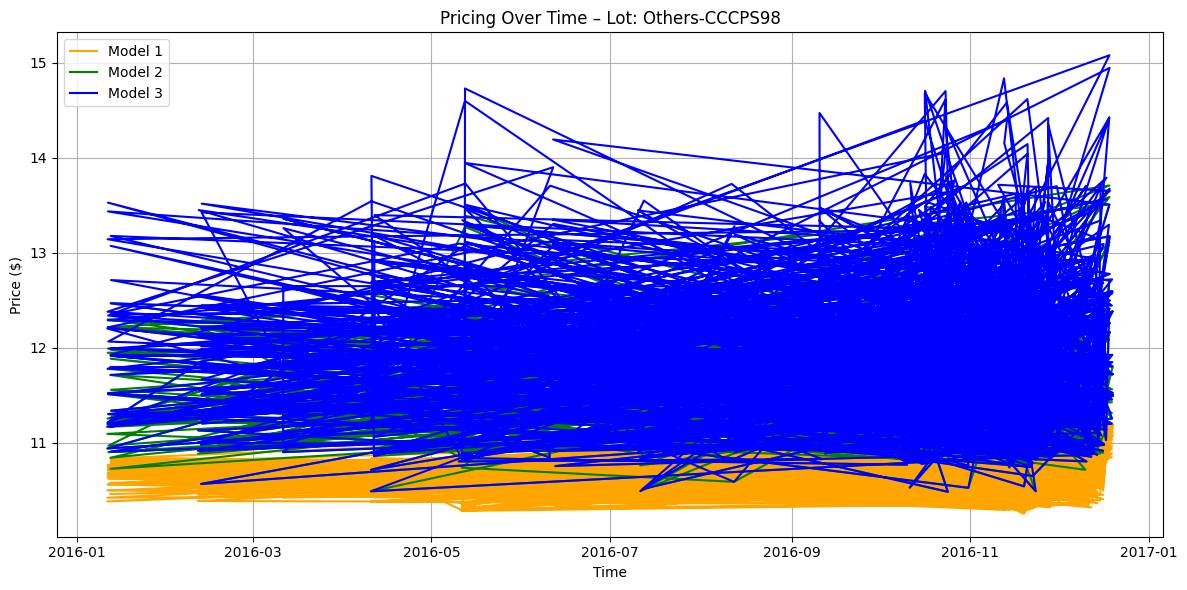

In [30]:
import matplotlib.pyplot as plt

df['timestamp'] = pd.to_datetime(df['timestamp'])

lot = df['lot_id'].unique()[0]
subset = df[df['lot_id'] == lot]

plt.figure(figsize=(12, 6))
plt.plot(subset['timestamp'], subset['price_model_1'], label='Model 1', color='orange')
plt.plot(subset['timestamp'], subset['price_model_2'], label='Model 2', color='green')
plt.plot(subset['timestamp'], subset['price_model_3'], label='Model 3', color='blue')

plt.title(f'Pricing Over Time – Lot: {lot}')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
df[['price_model_1', 'price_model_2', 'price_model_3']].describe()

,price_model_1,price_model_2,price_model_3
count,18368.000000,18368.000000,18368.000000
mean,11.018237,11.672140,11.872107
std,0.492286,0.611438,0.741454
min,10.006932,9.924269,9.924269
25%,10.614221,11.220249,11.345695
50%,10.992248,11.621043,11.808809
75%,11.402062,12.079362,12.302233
max,12.082687,13.998538,15.078353


In [32]:
df['reroute_flag'].value_counts()

,count
reroute_flag,
False,18171
True,197


In [33]:
df[['price_model_1', 'price_model_2', 'price_model_3']].applymap(lambda x: 5 <= x <= 20).all()

/tmp/ipython-input-33-2225183645.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[['price_model_1', 'price_model_2', 'price_model_3']].applymap(lambda x: 5 <= x <= 20).all()


,0
price_model_1,True
price_model_2,True
price_model_3,True


In [34]:
df['delta_1_vs_3'] = df['price_model_3'] - df['price_model_1']
df[['lot_id', 'timestamp', 'price_model_1', 'price_model_3', 'delta_1_vs_3']].sort_values(by='delta_1_vs_3', ascending=False).head()

,lot_id,timestamp,price_model_1,price_model_3,delta_1_vs_3
9106,Others-CCCPS135a,2016-06-11 12:26:00,10.494463,14.856010,4.361547
13175,Others-CCCPS202,2016-11-20 12:01:00,10.525707,14.808255,4.282549
11518,Others-CCCPS135a,2016-11-13 12:27:00,10.557816,14.817428,4.259612
15773,Others-CCCPS119a,2016-11-13 12:00:00,10.337496,14.570075,4.232579
3656,Others-CCCPS135a,2016-11-20 12:01:00,10.601597,14.829870,4.228273


# New Section